In [3]:
from argparse import ArgumentParser
import logging

from einops import rearrange
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
import torch
import torch.optim as optim

from src.blocks import UNet
from src.score_matching import ScoreMatchingModel, ScoreMatchingModelConfig

import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torchvision import datasets
from torchvision.transforms import Resize, InterpolationMode
import ssl

In [30]:
iterations = 2000
batch_size = 256
device = 'cuda'
load_trained = 1

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load data from https://www.openml.org/d/554
# (70000, 784) values between 0-255

ssl._create_default_https_context = ssl._create_unverified_context

import torch.utils.data as data_utils

# Select training_set and testing_set
transform =  transforms.Compose([transforms.Resize(32), transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])


test_loader = datasets.MNIST("data", 
                                train= False,
                                download=True,
                                transform=transform)

test_loader = torch.utils.data.DataLoader(test_loader, batch_size=10000, shuffle=True, num_workers=0)

x = next(iter(test_loader))[0]
x = x.view(-1,32*32).numpy()

nn_module = UNet(1, 128, (1, 2, 4, 8))
model = ScoreMatchingModel(
    nn_module=nn_module,
    input_shape=(1, 32, 32,),
    config=ScoreMatchingModelConfig(
        sigma_min=0.002,
        sigma_max=80.0,
        sigma_data=1.0,
    ),
)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)

if load_trained:
    model.load_state_dict(torch.load("./ckpts/mnist_trained.pt",map_location=torch.device(device)))
else:
    for step_num in range(iterations):
        x_batch = x[np.random.choice(len(x), batch_size)]
        x_batch = torch.from_numpy(x_batch).to(device)
        x_batch = rearrange(x_batch, "b (h w) -> b () h w", h=32, w=32)
        optimizer.zero_grad()
        loss = model.loss(x_batch).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        if step_num % 100 == 0:
            logger.info(f"Iter: {step_num}\t" + f"Loss: {loss.data:.2f}\t")
    torch.save(model.state_dict(), "./ckpts/mnist_trained.pt")

model.eval()

input_sd = 127
input_mean = 127
x_vis = x[:32] * input_sd + input_mean

# Degraded images
x_true = x[:32].reshape(32, 1, 32, 32).copy()

# Downscale and upscale functions
def downscale(image, factor):
    # Convert numpy image to tensor
    image = torch.tensor(image).unsqueeze(0)  # Add batch dimension
    downscale_transform = Resize((32 // factor, 32 // factor), interpolation=InterpolationMode.BILINEAR)
    downscaled_image = downscale_transform(image)
    return downscaled_image.squeeze(0).numpy()  # Remove batch dimension

def upscale(image, factor):
    # Convert numpy image to tensor
    image = torch.tensor(image).unsqueeze(0)  # Add batch dimension
    upscale_transform = Resize((32, 32), interpolation=InterpolationMode.BILINEAR)
    upscaled_image = upscale_transform(image)
    return upscaled_image.squeeze(0).numpy()  # Remove batch dimension

# Task 1: Upscaling
downscale_factor = 2
x_downscaled = np.array([downscale(im, downscale_factor) for im in x_true])
x_upscaled = np.array([upscale(im, downscale_factor) for im in x_downscaled])

# Task 2: Inpainting
mask_quarter = np.ones_like(x_true)
mask_quarter[:, :, :16, :16] = 0  # Missing top-left quarter
x_inpainted_quarter = x_true * mask_quarter

mask_half = np.ones_like(x_true)
mask_half[:, :, :16, :] = 0  # Missing top half
x_inpainted_half = x_true * mask_half

In [39]:
def compute_noise_value(sigma_noise, sigma_data):
    return sigma_noise / np.sqrt(sigma_noise**2 + sigma_data**2)

num_sampling_timesteps
7
tensor([0.3333, 0.2857, 0.2381, 0.1905, 0.1429, 0.0952, 0.0476, 0.0000],
       device='cuda:0')
tensor(0.5736, device='cuda:0')
0
tensor(0.5736, device='cuda:0')
1
tensor(0.4789, device='cuda:0')
2
tensor(0.3908, device='cuda:0')
3
tensor(0.3076, device='cuda:0')
4
tensor(0.2282, device='cuda:0')
5
tensor(0.1514, device='cuda:0')
6
tensor(0.0763, device='cuda:0')
0
1
2
3
4
5
6
7
num_sampling_timesteps
4
tensor([0.2000, 0.1500, 0.1000, 0.0500, 0.0000], device='cuda:0')
tensor(0.3239, device='cuda:0')
0
tensor(0.3239, device='cuda:0')
1
tensor(0.2399, device='cuda:0')
2
tensor(0.1589, device='cuda:0')
3
tensor(0.0800, device='cuda:0')
0
1
2
3
4
num_sampling_timesteps
4
tensor([0.2000, 0.1500, 0.1000, 0.0500, 0.0000], device='cuda:0')
tensor(0.3239, device='cuda:0')
0
tensor(0.3239, device='cuda:0')
1
tensor(0.2399, device='cuda:0')
2
tensor(0.1589, device='cuda:0')
3
tensor(0.0800, device='cuda:0')
0
1
2
3
4


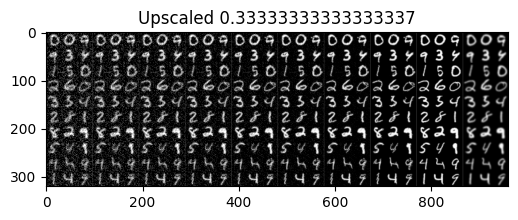

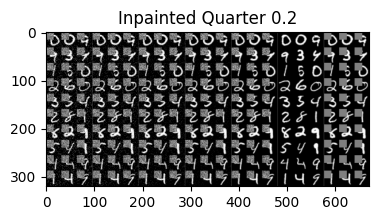

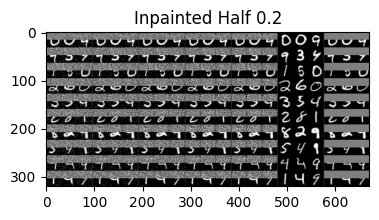

In [54]:
# Sample generation
for degraded_images, noise, description in [
    (x_upscaled, compute_noise_value((0.5)**0.5,1),"Upscaled"),
    (x_inpainted_quarter, compute_noise_value((0.25)**0.5, 1.0), "Inpainted Quarter"),
    (x_inpainted_half, compute_noise_value((0.5)**0.5,1), "Inpainted Half")
    ]:
    samples = model.sample(bsz=32, noise=noise, x0=degraded_images, device=device).cpu().numpy()
    samples = rearrange(samples, "t b () h w -> t b (h w)")
    samples = samples * input_sd + input_mean

    nrows, ncols = 10, 3
    percents = min(len(samples),20)

    raster = np.zeros((nrows * 32, ncols * 32 * (percents + 2)), dtype=np.float32)

    degraded_images = degraded_images * input_sd + input_mean        

    # blocks of resulting images. Last row is the degraded image, before last row: the noise-free images. 
    # First rows show the denoising progression
    for percent_idx in range(percents):
        itr_num = int(round(percent_idx / (percents-1) * (len(samples)-1)))
        print(itr_num)
        for i in range(nrows * ncols):
            row, col = i // ncols, i % ncols
            offset = 32 * ncols * (percent_idx)
            raster[32 * row : 32 * (row + 1), offset + 32 * col : offset + 32 * (col + 1)] = samples[itr_num][i].reshape(32, 32)

    # last block of nrow,ncol of input images
    for i in range(nrows * ncols):
        offset = 32 * ncols * percents
        row, col = i // ncols, i % ncols
        raster[32 * row : 32 * (row + 1), offset + 32 * col : offset + 32 * (col + 1)] = x_vis[i].reshape(32, 32)

    for i in range(nrows * ncols):
        offset =  32 * ncols * (percents+1)
        row, col = i // ncols, i % ncols
        raster[32 * row : 32 * (row + 1), offset + 32 * col : offset + 32 * (col + 1)] = degraded_images[i].reshape(32, 32)

    raster[:,::32*3] = 64

    plt.figure(figsize = (20,2))
    plt.imshow(raster, vmin=0, vmax=255, cmap='gray')
    plt.title(f"{description} {noise}")


num_sampling_timesteps
2
tensor([0.1000, 0.0500, 0.0000], device='cuda:0')
tensor(0.1589, device='cuda:0')
0
tensor(0.1589, device='cuda:0')
1
tensor(0.0800, device='cuda:0')
0
1
2
num_sampling_timesteps
4
tensor([0.2000, 0.1500, 0.1000, 0.0500, 0.0000], device='cuda:0')
tensor(0.3239, device='cuda:0')
0
tensor(0.3239, device='cuda:0')
1
tensor(0.2399, device='cuda:0')
2
tensor(0.1589, device='cuda:0')
3
tensor(0.0800, device='cuda:0')
0
1
2
3
4
num_sampling_timesteps
6
tensor([0.3000, 0.2500, 0.2000, 0.1500, 0.1000, 0.0500, 0.0000],
       device='cuda:0')
tensor(0.5066, device='cuda:0')
0
tensor(0.5066, device='cuda:0')
1
tensor(0.4123, device='cuda:0')
2
tensor(0.3239, device='cuda:0')
3
tensor(0.2399, device='cuda:0')
4
tensor(0.1589, device='cuda:0')
5
tensor(0.0800, device='cuda:0')
0
1
2
3
4
5
6
num_sampling_timesteps
8
tensor([0.4000, 0.3500, 0.3000, 0.2500, 0.2000, 0.1500, 0.1000, 0.0500, 0.0000],
       device='cuda:0')
tensor(0.7208, device='cuda:0')
0
tensor(0.7208, device=

/tmp/ipykernel_4186/2882682773.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (20,2))


4
tensor(0.5066, device='cuda:0')
5
tensor(0.4123, device='cuda:0')
6
tensor(0.3239, device='cuda:0')
7
tensor(0.2399, device='cuda:0')
8
tensor(0.1589, device='cuda:0')
9
tensor(0.0800, device='cuda:0')
0
1
2
3
4
5
6
7
8
9
10
num_sampling_timesteps
12
tensor([0.6000, 0.5500, 0.5000, 0.4500, 0.4000, 0.3500, 0.3000, 0.2500, 0.2000,
        0.1500, 0.1000, 0.0500, 0.0000], device='cuda:0')
tensor(1.3572, device='cuda:0')
0
tensor(1.3572, device='cuda:0')
1
tensor(1.1568, device='cuda:0')
2
tensor(0.9896, device='cuda:0')
3
tensor(0.8463, device='cuda:0')
4
tensor(0.7208, device='cuda:0')
5
tensor(0.6086, device='cuda:0')
6
tensor(0.5066, device='cuda:0')
7
tensor(0.4123, device='cuda:0')
8
tensor(0.3239, device='cuda:0')
9
tensor(0.2399, device='cuda:0')
10
tensor(0.1589, device='cuda:0')
11
tensor(0.0800, device='cuda:0')
0
1
2
3
4
5
6
7
8
9
10
11
12
num_sampling_timesteps
14
tensor([0.7000, 0.6500, 0.6000, 0.5500, 0.5000, 0.4500, 0.4000, 0.3500, 0.3000,
        0.2500, 0.2000, 0.1500, 

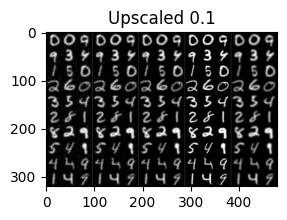

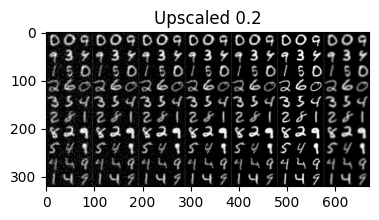

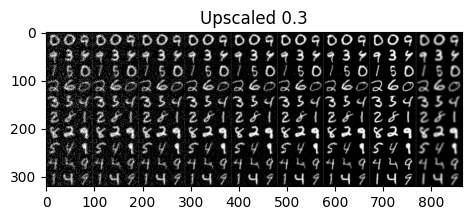

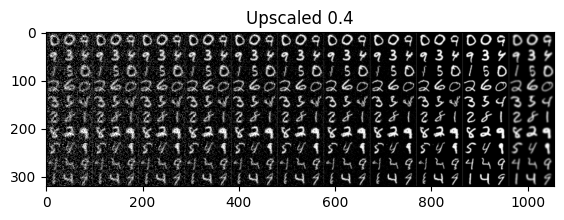

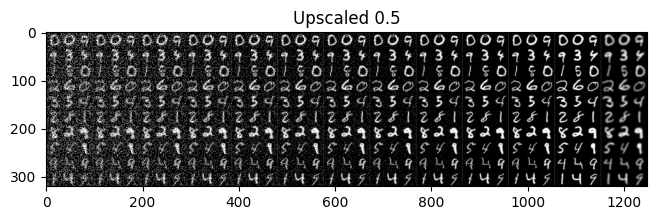

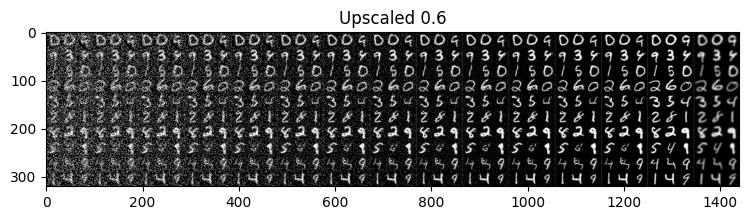

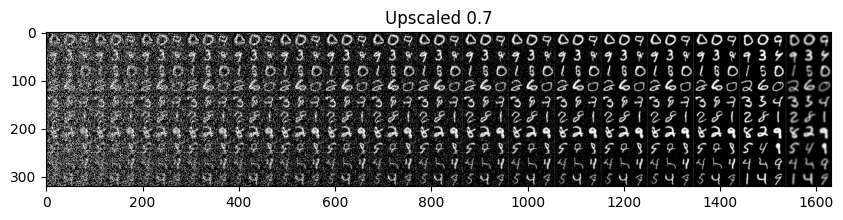

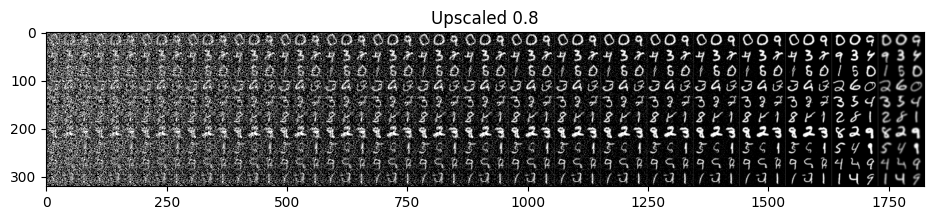

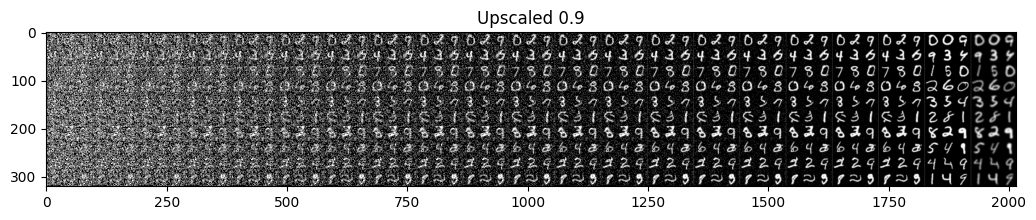

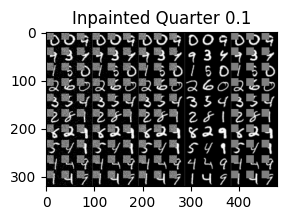

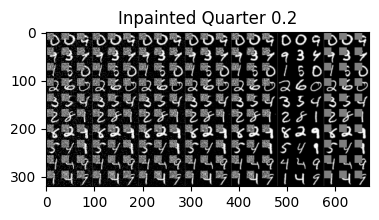

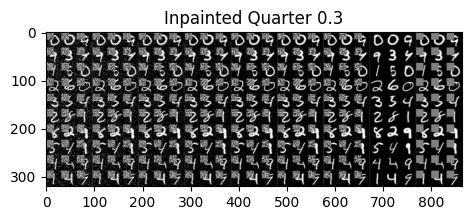

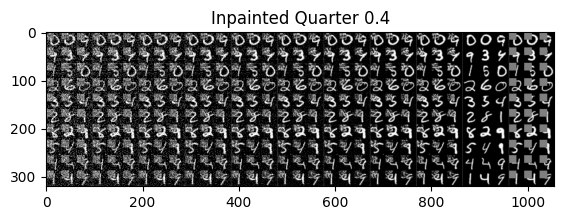

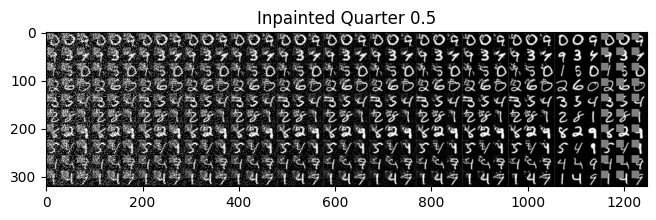

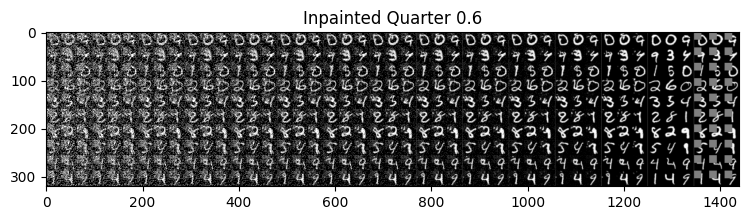

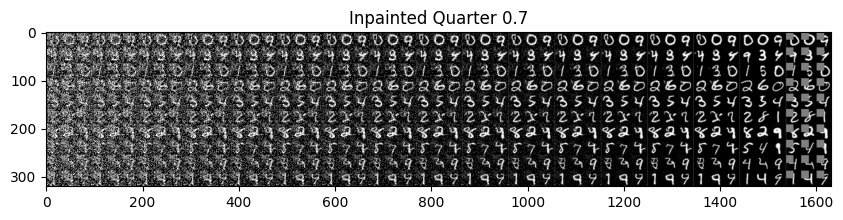

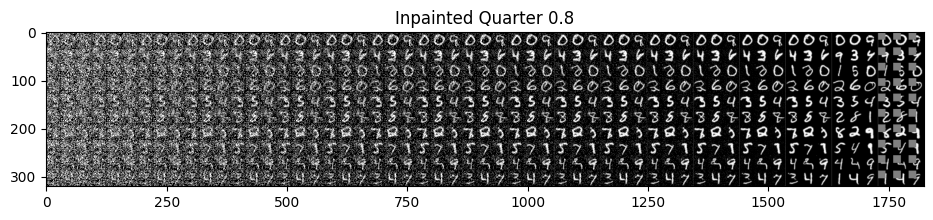

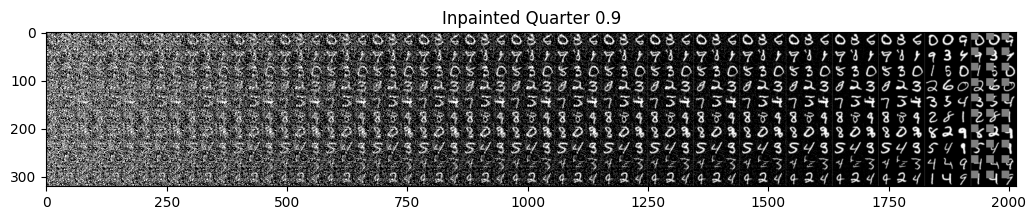

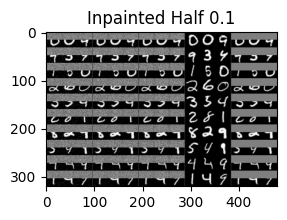

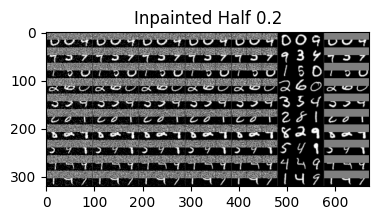

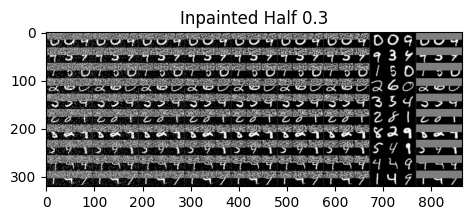

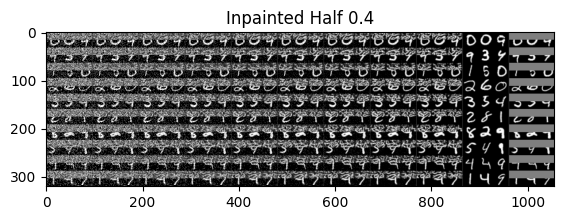

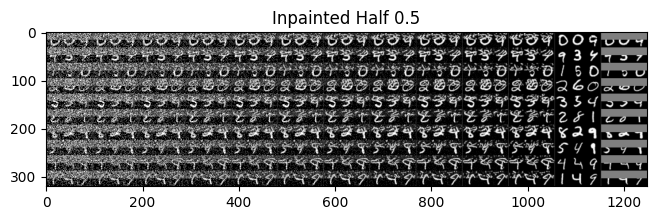

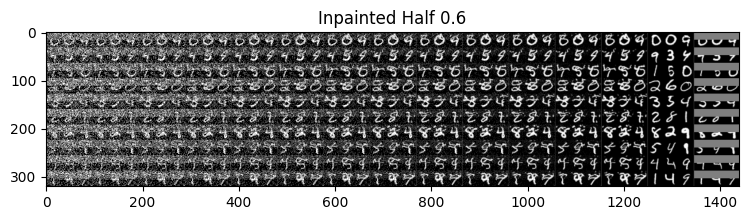

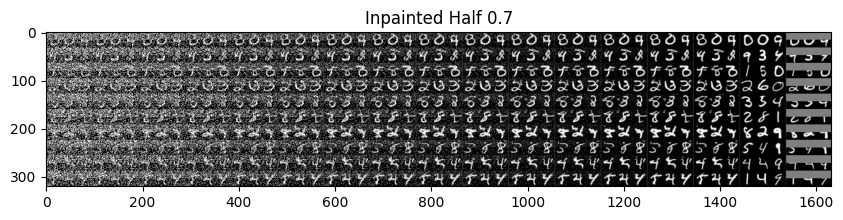

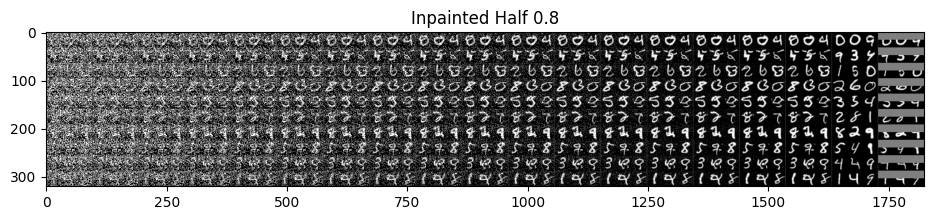

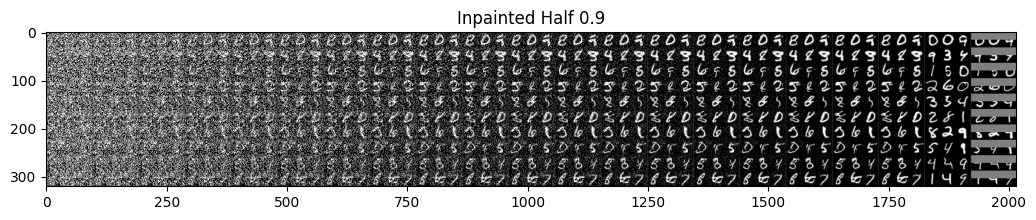

In [37]:
# Sample generation
for degraded_images, noise, description in [
    (x_upscaled, 0.1, "Upscaled"),
    (x_upscaled, 0.2, "Upscaled"),
    (x_upscaled, 0.3, "Upscaled"),
    (x_upscaled, 0.4, "Upscaled"),
    (x_upscaled, 0.5, "Upscaled"),
    (x_upscaled, 0.6, "Upscaled"),
    (x_upscaled, 0.7, "Upscaled"),
    (x_upscaled, 0.8, "Upscaled"),
    (x_upscaled, 0.9, "Upscaled"),
    (x_inpainted_quarter, 0.1, "Inpainted Quarter"),
    (x_inpainted_quarter, 0.2, "Inpainted Quarter"),
    (x_inpainted_quarter, 0.3, "Inpainted Quarter"),
    (x_inpainted_quarter, 0.4, "Inpainted Quarter"),
    (x_inpainted_quarter, 0.5, "Inpainted Quarter"),
    (x_inpainted_quarter, 0.6, "Inpainted Quarter"),
    (x_inpainted_quarter, 0.7, "Inpainted Quarter"),
    (x_inpainted_quarter, 0.8, "Inpainted Quarter"),
    (x_inpainted_quarter, 0.9, "Inpainted Quarter"),
    (x_inpainted_half, 0.1, "Inpainted Half"),
    (x_inpainted_half, 0.2, "Inpainted Half"),
    (x_inpainted_half, 0.3, "Inpainted Half"),
    (x_inpainted_half, 0.4, "Inpainted Half"),
    (x_inpainted_half, 0.5, "Inpainted Half"),
    (x_inpainted_half, 0.6, "Inpainted Half"),
    (x_inpainted_half, 0.7, "Inpainted Half"),
    (x_inpainted_half, 0.8, "Inpainted Half"),
    (x_inpainted_half, 0.9, "Inpainted Half")
    ]:
    samples = model.sample(bsz=32, noise=noise, x0=degraded_images, device=device).cpu().numpy()
    samples = rearrange(samples, "t b () h w -> t b (h w)")
    samples = samples * input_sd + input_mean

    nrows, ncols = 10, 3
    percents = min(len(samples),20)

    raster = np.zeros((nrows * 32, ncols * 32 * (percents + 2)), dtype=np.float32)

    degraded_images = degraded_images * input_sd + input_mean        

    # blocks of resulting images. Last row is the degraded image, before last row: the noise-free images. 
    # First rows show the denoising progression
    for percent_idx in range(percents):
        itr_num = int(round(percent_idx / (percents-1) * (len(samples)-1)))
        print(itr_num)
        for i in range(nrows * ncols):
            row, col = i // ncols, i % ncols
            offset = 32 * ncols * (percent_idx)
            raster[32 * row : 32 * (row + 1), offset + 32 * col : offset + 32 * (col + 1)] = samples[itr_num][i].reshape(32, 32)

    # last block of nrow,ncol of input images
    for i in range(nrows * ncols):
        offset = 32 * ncols * percents
        row, col = i // ncols, i % ncols
        raster[32 * row : 32 * (row + 1), offset + 32 * col : offset + 32 * (col + 1)] = x_vis[i].reshape(32, 32)

    for i in range(nrows * ncols):
        offset =  32 * ncols * (percents+1)
        row, col = i // ncols, i % ncols
        raster[32 * row : 32 * (row + 1), offset + 32 * col : offset + 32 * (col + 1)] = degraded_images[i].reshape(32, 32)

    raster[:,::32*3] = 64

    plt.figure(figsize = (20,2))
    plt.imshow(raster, vmin=0, vmax=255, cmap='gray')
    plt.title(f"{description} {noise}")


Alternative Formula: Signal-to-Noise Ratio (SNR)
The Signal-to-Noise Ratio (SNR) is a common measure used to quantify the amount of noise present relative to the signal strength. The formula for the noise value based on SNR is:

noise_value=  1 / 1+SNR
 

Where:

SNR is the Signal-to-Noise Ratio, defined as:
SNR = 𝜎data^2 / 𝜎noise^2
 
Here’s the breakdown:

𝜎data^2 is the variance of the clean signal (image).

𝜎noise^2 is the variance of the noise.

Motivation for the SNR-Based Formula
Direct Relationship: The SNR provides a direct measure of how much stronger the signal is compared to the noise. A high SNR indicates a clean image with minimal noise, and a low SNR indicates a noisy image. Using SNR directly helps in interpreting the noise value in relation to the signal strength.

Normalizing Effect: The formula normalizes the noise value to be between 0 and 1. When the SNR is high (clean signal), the noise value approaches 0, indicating minimal noise. When the SNR is low (noisy signal), the noise value approaches 1, indicating high noise.

In [45]:
def compute_noise_value(sigma_noise, sigma_data):
    snr = (sigma_data ** 2) / (sigma_noise ** 2)
    return 1 / (1 + snr)

num_sampling_timesteps
7
tensor([0.3333, 0.2857, 0.2381, 0.1905, 0.1429, 0.0952, 0.0476, 0.0000],
       device='cuda:0')
tensor(0.5736, device='cuda:0')
0
tensor(0.5736, device='cuda:0')
1
tensor(0.4789, device='cuda:0')
2
tensor(0.3908, device='cuda:0')
3
tensor(0.3076, device='cuda:0')
4
tensor(0.2282, device='cuda:0')
5
tensor(0.1514, device='cuda:0')
6
tensor(0.0763, device='cuda:0')
0
1
2
3
4
5
6
7
num_sampling_timesteps
10
tensor([0.5000, 0.4500, 0.4000, 0.3500, 0.3000, 0.2500, 0.2000, 0.1500, 0.1000,
        0.0500, 0.0000], device='cuda:0')
tensor(0.9896, device='cuda:0')
0
tensor(0.9896, device='cuda:0')
1
tensor(0.8463, device='cuda:0')
2
tensor(0.7208, device='cuda:0')
3
tensor(0.6086, device='cuda:0')
4
tensor(0.5066, device='cuda:0')
5
tensor(0.4123, device='cuda:0')
6
tensor(0.3239, device='cuda:0')
7
tensor(0.2399, device='cuda:0')
8
tensor(0.1589, device='cuda:0')
9
tensor(0.0800, device='cuda:0')
0
1
2
3
4
5
6
7
8
9
10
num_sampling_timesteps
14
tensor([0.6667, 0.6190,

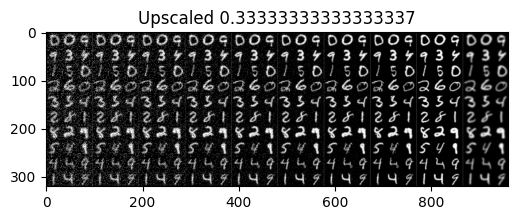

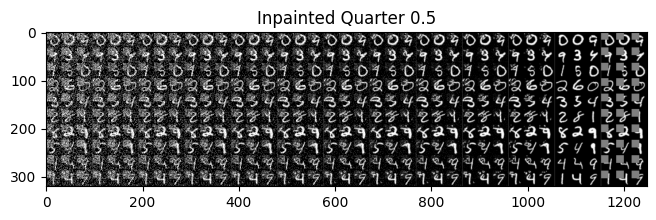

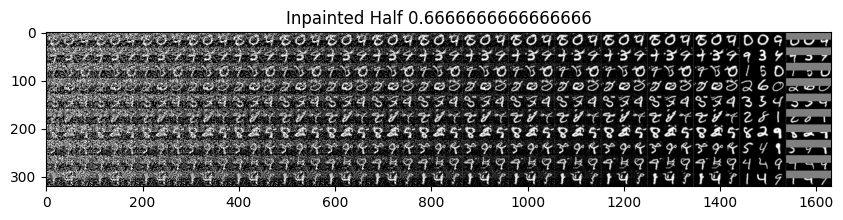

In [60]:
C = 0.5

# Sample generation
for degraded_images, noise, description in [
    (x_upscaled, compute_noise_value((0.5)**0.5,1),"Upscaled"),
    (x_inpainted_quarter, compute_noise_value((0.25)**0.5, 1-C), "Inpainted Quarter"),
    (x_inpainted_half, compute_noise_value((0.5)**0.5,1-C), "Inpainted Half")
    ]:
    samples = model.sample(bsz=32, noise=noise, x0=degraded_images, device=device).cpu().numpy()
    samples = rearrange(samples, "t b () h w -> t b (h w)")
    samples = samples * input_sd + input_mean

    nrows, ncols = 10, 3
    percents = min(len(samples),20)

    raster = np.zeros((nrows * 32, ncols * 32 * (percents + 2)), dtype=np.float32)

    degraded_images = degraded_images * input_sd + input_mean        

    # blocks of resulting images. Last row is the degraded image, before last row: the noise-free images. 
    # First rows show the denoising progression
    for percent_idx in range(percents):
        itr_num = int(round(percent_idx / (percents-1) * (len(samples)-1)))
        print(itr_num)
        for i in range(nrows * ncols):
            row, col = i // ncols, i % ncols
            offset = 32 * ncols * (percent_idx)
            raster[32 * row : 32 * (row + 1), offset + 32 * col : offset + 32 * (col + 1)] = samples[itr_num][i].reshape(32, 32)

    # last block of nrow,ncol of input images
    for i in range(nrows * ncols):
        offset = 32 * ncols * percents
        row, col = i // ncols, i % ncols
        raster[32 * row : 32 * (row + 1), offset + 32 * col : offset + 32 * (col + 1)] = x_vis[i].reshape(32, 32)

    for i in range(nrows * ncols):
        offset =  32 * ncols * (percents+1)
        row, col = i // ncols, i % ncols
        raster[32 * row : 32 * (row + 1), offset + 32 * col : offset + 32 * (col + 1)] = degraded_images[i].reshape(32, 32)

    raster[:,::32*3] = 64

    plt.figure(figsize = (20,2))
    plt.imshow(raster, vmin=0, vmax=255, cmap='gray')
    plt.title(f"{description} {noise}")
